In [1]:
import pandas as pd
import numpy as np
import seaborn as sb

# Approach
- Clean data during EDA 
- Feature generate 
- Test out with different models
- Hyper paramater tuning

__Even though this is a time series data, I will be treating the problem as a regression problem, with the inclusion of lagged features. This is because the target variable is too complex to be predicted by time-series models such as ARIMA.__

In [2]:
item_cat=pd.read_csv("competitive-data-science-predict-future-sales/item_categories.csv")
items=pd.read_csv("competitive-data-science-predict-future-sales/items.csv")
sales_train=pd.read_csv("competitive-data-science-predict-future-sales/sales_train.csv")
shops=pd.read_csv("competitive-data-science-predict-future-sales/shops.csv")
test=pd.read_csv("competitive-data-science-predict-future-sales/test.csv")

In [3]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


<AxesSubplot:xlabel='item_cnt_day'>

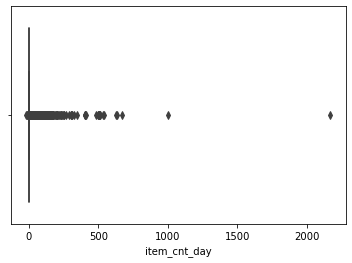

In [4]:
sb.boxplot(x=sales_train.item_cnt_day)

<AxesSubplot:xlabel='item_price'>

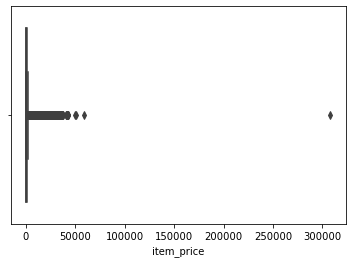

In [5]:
sb.boxplot(x=sales_train.item_price)

In [6]:
#sales_train['date'] = sales_train['date'].astype('datetime64[ns]')
#sales_train['year']=sales_train['date'].dt.year
#sales_train['month']=sales_train['date'].dt.month
#sales_train

In [7]:
print(shops[shops.shop_id.isin([0, 57])]['shop_name'])
print(shops[shops.shop_id.isin([1, 58])]['shop_name'])
print(shops[shops.shop_id.isin([40, 39])]['shop_name'])

0     !Якутск Орджоникидзе, 56 фран
57          Якутск Орджоникидзе, 56
Name: shop_name, dtype: object
1     !Якутск ТЦ "Центральный" фран
58          Якутск ТЦ "Центральный"
Name: shop_name, dtype: object
39              РостовНаДону ТРК "Мегацентр Горизонт"
40    РостовНаДону ТРК "Мегацентр Горизонт" Островной
Name: shop_name, dtype: object


In [8]:
item_price_df=sales_train[["item_id","item_price"]].groupby('item_id').mean()
item_price_df.head()

,item_price
item_id,
0,58.0
1,4490.0
2,58.0
3,79.0
4,58.0


__From the EDA, we can see that items sold a day and item prices has many outliers. Shop names are also similar even though they have different ids, implying they might actually be the same shop__

In [9]:
#Data preprocessing
sales_train = sales_train[(sales_train.item_price < 100000) & (sales_train.item_price > 0)]
sales_train = sales_train[sales_train.item_cnt_day < 1001]

sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

sales_train.loc[sales_train.shop_id == 40, 'shop_id'] = 39
test.loc[test.shop_id == 40, 'shop_id'] = 39

sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


__Creating the training set, with item count per month__

In [10]:

import numpy as np
from itertools import product
index_cols = ['shop_id', 'item_id', 'date_block_num']

df = []
for block_num in sales_train['date_block_num'].unique():
    cur_shops = sales_train.loc[sales_train['date_block_num']
                          == block_num, 'shop_id'].unique()
    cur_items = sales_train.loc[sales_train['date_block_num']
                          == block_num, 'item_id'].unique()
    df.append(
        np.array(list(product(*[cur_shops, cur_items, [block_num]])), dtype='int32'))

df = pd.DataFrame(np.vstack(df), columns=index_cols, dtype=np.int32)

group = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg(
    {'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

df = pd.merge(df, group, on=index_cols, how='left')
df['item_cnt_month'] = (df['item_cnt_month']
                        .fillna(0)
                        .clip(0, 20)
                        .astype(np.float16))

df

,shop_id,item_id,date_block_num,item_cnt_month
0,59,22154,0,1.0
1,59,2552,0,0.0
2,59,2554,0,0.0
3,59,2555,0,0.0
4,59,2564,0,0.0
...,...,...,...,...
10842072,21,7635,33,0.0
10842073,21,7638,33,0.0
10842074,21,7640,33,0.0
10842075,21,7632,33,0.0


## Constructing the test set , in this case we are trying to predict items sold in month of November 2015

In [11]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [12]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test = test.drop(columns=['ID'])
df = pd.concat([df, test], ignore_index=True, sort=False, keys=index_cols) #combining the train and test sets
df.fillna(0, inplace=True)
df

,shop_id,item_id,date_block_num,item_cnt_month
0,59,22154,0,1.0
1,59,2552,0,0.0
2,59,2554,0,0.0
3,59,2555,0,0.0
4,59,2564,0,0.0
...,...,...,...,...
11056272,45,18454,34,0.0
11056273,45,16188,34,0.0
11056274,45,15757,34,0.0
11056275,45,19648,34,0.0


In [13]:
#df=pd.merge(df,item_price_df,on="item_id",how="left")
#df

In [14]:
#df["item_price"].fillna(df["item_price"].mean(),inplace=True)

In [15]:
#merging the datasets to create training dataset
#df=pd.merge(df,items,how="left",on="item_id")
#df=pd.merge(df,item_cat,how="left",on="item_category_id")
#df


## Feature engineering for item category names

In [16]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder() #label encoding to encode categorical variables

map_dict = {
            'Чистые носители (штучные)': 'Чистые носители',
            'Чистые носители (шпиль)' : 'Чистые носители',
            'PC ': 'Аксессуары',
            'Служебные': 'Служебные '
            }

items = pd.merge(items, item_cat, on='item_category_id')

items['item_category'] = items['item_category_name'].apply(lambda x: x.split('-')[0])
items['item_category'] = items['item_category'].apply(lambda x: map_dict[x] if x in map_dict.keys() else x)
items['item_category_common'] = le.fit_transform(items['item_category'])

items['item_category_code'] = le.fit_transform(items['item_category_name'])
items = items[['item_id', 'item_category_common', 'item_category_code']]
df = pd.merge(df, items, on=['item_id'], how='left')
df

,shop_id,item_id,date_block_num,item_cnt_month,item_category_common,item_category_code
0,59,22154,0,1.0,11,37
1,59,2552,0,0.0,13,58
2,59,2554,0,0.0,13,58
3,59,2555,0,0.0,13,56
4,59,2564,0,0.0,13,59
...,...,...,...,...,...,...
11056272,45,18454,34,0.0,13,55
11056273,45,16188,34,0.0,14,64
11056274,45,15757,34,0.0,13,55
11056275,45,19648,34,0.0,11,40


## Feature engineering for shop location coordinates

In [17]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [18]:
shops['city_name'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['city_name'].unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [19]:
#cleaning the data, found out that these names are city names and Якутск is the actual city name
shops["city_name"].replace({"!Якутск":"Якутск"},inplace=True)
shops["city_name"].replace({"РостовНаДону":"Ростов На Дону"},inplace=True)


In [20]:
#testing if can gain longitude and latitudes
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")
location = geolocator.geocode("Ростов На Дону")
print((location.latitude, location.longitude))

(47.2213858, 39.7114196)


In [21]:
latitude=[]
longitude=[]
for state in shops["city_name"]:
    location=geolocator.geocode(str(state))
    try:
        latitude.append(location.latitude)
        longitude.append(location.longitude)
    except:
        latitude.append("not found")
        longitude.append("not found")

coordinates=pd.DataFrame(list(zip(latitude,longitude)),columns=[["latitude","longitude"]])
shops=pd.concat([shops,coordinates],axis=1)
shops.head()

,shop_name,shop_id,city_name,"(latitude,)","(longitude,)"
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,62.027287,129.732086
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,62.027287,129.732086
2,"Адыгея ТЦ ""Мега""",2,Адыгея,44.693901,40.152042
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,55.803623,37.964649
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,48.782102,44.777984


In [22]:

shops['city_name']=le.fit_transform(shops['city_name']).astype(np.int8)
shops.head()

,shop_name,shop_id,city_name,"(latitude,)","(longitude,)"
0,"!Якутск Орджоникидзе, 56 фран",0,29,62.027287,129.732086
1,"!Якутск ТЦ ""Центральный"" фран",1,29,62.027287,129.732086
2,"Адыгея ТЦ ""Мега""",2,0,44.693901,40.152042
3,"Балашиха ТРК ""Октябрь-Киномир""",3,1,55.803623,37.964649
4,"Волжский ТЦ ""Волга Молл""",4,2,48.782102,44.777984


In [23]:
df=pd.merge(df,shops,how="left",on="shop_id")
df.drop(columns="shop_name",inplace=True)
df

,shop_id,item_id,date_block_num,item_cnt_month,item_category_common,item_category_code,city_name,"(latitude,)","(longitude,)"
0,59,22154,0,1.0,11,37,30,57.626388,39.893371
1,59,2552,0,0.0,13,58,30,57.626388,39.893371
2,59,2554,0,0.0,13,58,30,57.626388,39.893371
3,59,2555,0,0.0,13,56,30,57.626388,39.893371
4,59,2564,0,0.0,13,59,30,57.626388,39.893371
...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,13,55,20,53.198627,50.113987
11056273,45,16188,34,0.0,14,64,20,53.198627,50.113987
11056274,45,15757,34,0.0,13,55,20,53.198627,50.113987
11056275,45,19648,34,0.0,11,40,20,53.198627,50.113987


## Our current dataset

In [24]:
#renaming weird column names
df.rename(columns={('latitude',): 'latitude', ('longitude',): 'longitude'}, inplace=True)
print(df.shape)
df.head()




(11056277, 9)


,shop_id,item_id,date_block_num,item_cnt_month,item_category_common,item_category_code,city_name,latitude,longitude
0,59,22154,0,1.0,11,37,30,57.626388,39.893371
1,59,2552,0,0.0,13,58,30,57.626388,39.893371
2,59,2554,0,0.0,13,58,30,57.626388,39.893371
3,59,2555,0,0.0,13,56,30,57.626388,39.893371
4,59,2564,0,0.0,13,59,30,57.626388,39.893371


## Adding lagged features 

In [25]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)] = df[col+'_lag_'+str(i)].astype('float16')
    return df

df = lag_feature(df, [1, 2, 3], 'item_cnt_month')
df

,shop_id,item_id,date_block_num,item_cnt_month,item_category_common,item_category_code,city_name,latitude,longitude,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,59,22154,0,1.0,11,37,30,57.626388,39.893371,NaN,NaN,NaN
1,59,2552,0,0.0,13,58,30,57.626388,39.893371,NaN,NaN,NaN
2,59,2554,0,0.0,13,58,30,57.626388,39.893371,NaN,NaN,NaN
3,59,2555,0,0.0,13,56,30,57.626388,39.893371,NaN,NaN,NaN
4,59,2564,0,0.0,13,59,30,57.626388,39.893371,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,13,55,20,53.198627,50.113987,1.0,0.0,0.0
11056273,45,16188,34,0.0,14,64,20,53.198627,50.113987,0.0,0.0,NaN
11056274,45,15757,34,0.0,13,55,20,53.198627,50.113987,0.0,0.0,0.0
11056275,45,19648,34,0.0,11,40,20,53.198627,50.113987,0.0,0.0,0.0


In [26]:
average_price=sales_train[["item_id","item_price"]].groupby("item_id").mean()
average_price

,item_price
item_id,
0,58.000000
1,4490.000000
2,58.000000
3,79.000000
4,58.000000
...,...
22165,59.000000
22166,150.000000
22167,297.686490


## Adding item price


In [27]:

df = pd.merge(df, average_price, on="item_id", how='left')

df

,shop_id,item_id,date_block_num,item_cnt_month,item_category_common,item_category_code,city_name,latitude,longitude,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_price
0,59,22154,0,1.0,11,37,30,57.626388,39.893371,NaN,NaN,NaN,702.932203
1,59,2552,0,0.0,13,58,30,57.626388,39.893371,NaN,NaN,NaN,937.888889
2,59,2554,0,0.0,13,58,30,57.626388,39.893371,NaN,NaN,NaN,1709.050000
3,59,2555,0,0.0,13,56,30,57.626388,39.893371,NaN,NaN,NaN,1123.101786
4,59,2564,0,0.0,13,59,30,57.626388,39.893371,NaN,NaN,NaN,340.152174
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,13,55,20,53.198627,50.113987,1.0,0.0,0.0,188.681084
11056273,45,16188,34,0.0,14,64,20,53.198627,50.113987,0.0,0.0,NaN,1256.975000
11056274,45,15757,34,0.0,13,55,20,53.198627,50.113987,0.0,0.0,0.0,198.113208
11056275,45,19648,34,0.0,11,40,20,53.198627,50.113987,0.0,0.0,0.0,98.096296


In [29]:
df.fillna(0, inplace=True)
df = df[(df['date_block_num'] > 2)]
df = df[(df['shop_id'] != 9)] #shop id 9 and 20 dont exist in the test data set
df = df[(df['shop_id'] != 20)]
df.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_category_common,item_category_code,city_name,latitude,longitude,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_price
1122795,25,8092,3,3.0,11,40,13,55.750446,37.617494,1.0,0.0,4.0,145.754233
1122796,25,7850,3,3.0,8,30,13,55.750446,37.617494,5.0,1.0,6.0,196.991600
1122797,25,8051,3,3.0,14,66,13,55.750446,37.617494,0.0,0.0,0.0,27.083333
1122798,25,8088,3,1.0,13,55,13,55.750446,37.617494,1.0,1.0,0.0,186.380952
1122799,25,8089,3,1.0,13,55,13,55.750446,37.617494,0.0,1.0,0.0,196.164532


<AxesSubplot:xlabel='item_price'>

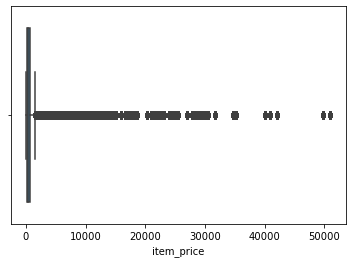

In [31]:
sb.boxplot(x=df['item_price'])

In [32]:
df['item_price'].describe()

count    9.896473e+06
mean     7.085609e+02
std      1.396885e+03
min      0.000000e+00
25%      1.965591e+02
50%      3.166578e+02
75%      7.561393e+02
max      5.099900e+04
Name: item_price, dtype: float64

In [33]:
df['item_price']=df['item_price'].clip(0,900)


## Normalization of numeric variables

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(pd.DataFrame(df['item_price']))


MinMaxScaler()

In [35]:
df['item_price']=scaler.transform(pd.DataFrame(df['item_price']))
df

,shop_id,item_id,date_block_num,item_cnt_month,item_category_common,item_category_code,city_name,latitude,longitude,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_price
1122795,25,8092,3,3.0,11,40,13,55.750446,37.617494,1.0,0.0,4.0,0.161949
1122796,25,7850,3,3.0,8,30,13,55.750446,37.617494,5.0,1.0,6.0,0.218880
1122797,25,8051,3,3.0,14,66,13,55.750446,37.617494,0.0,0.0,0.0,0.030093
1122798,25,8088,3,1.0,13,55,13,55.750446,37.617494,1.0,1.0,0.0,0.207090
1122799,25,8089,3,1.0,13,55,13,55.750446,37.617494,0.0,1.0,0.0,0.217961
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,13,55,20,53.198627,50.113987,1.0,0.0,0.0,0.209646
11056273,45,16188,34,0.0,14,64,20,53.198627,50.113987,0.0,0.0,0.0,1.000000
11056274,45,15757,34,0.0,13,55,20,53.198627,50.113987,0.0,0.0,0.0,0.220126
11056275,45,19648,34,0.0,11,40,20,53.198627,50.113987,0.0,0.0,0.0,0.108996


In [36]:
print(df.columns)
features=['shop_id', 'item_id', 'date_block_num', 
       'item_category_common', 'item_category_code', 'city_name', 'latitude',
       'longitude', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'item_price']

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month',
       'item_category_common', 'item_category_code', 'city_name', 'latitude',
       'longitude', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'item_price'],
      dtype='object')


In [37]:
from sklearn.utils import shuffle
#this is for submission
test_X=df[features][df[features].date_block_num==34]

df=df[df.date_block_num<34] #remove those that are for the test set


train_X = df[features][df[features].date_block_num < 29]
train_y = df[df.date_block_num < 29]['item_cnt_month']
val_X = df[features][df[features].date_block_num >=29]
val_y = df[df.date_block_num >=29]['item_cnt_month']








In [42]:
int(val_y.shape[0])/int(train_y.shape[0])

0.12997681407107076

In [44]:
#testing on LGBM Regressor since no GPU 

import lightgbm as lgb
params = {
    'objective': 'rmse',
    'metric': 'rmse',
    'num_leaves': 100,
    'learning_rate': 0.004,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.6,
    'bagging_freq': 10,
    'seed': 1,
    'verbose': 1,
    'force_row_wise' : True
}

feature_name_indexes = [ 'item_category_common',
                        'item_category_code', 
                        'city_name']

lgb_train = lgb.Dataset(train_X, train_y)
lgb_eval = lgb.Dataset(val_X, val_y, reference=lgb_train)


evals_result = {}
model = lgb.train(
        params, 
        lgb_train,
        num_boost_round= 3000,
        valid_sets=(lgb_train, lgb_eval), 
        feature_name = features,
        categorical_feature = feature_name_indexes,
        verbose_eval=50, 
        evals_result = evals_result,
        early_stopping_rounds = 100)

[LightGBM] [Info] Total Bins 844
[LightGBM] [Info] Number of data points in the train set: 8568559, number of used features: 12
[LightGBM] [Info] Start training from score 0.298692
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 1.1546	valid_1's rmse: 1.00774
[100]	training's rmse: 1.10071	valid_1's rmse: 0.962882
[150]	training's rmse: 1.05764	valid_1's rmse: 0.928181
[200]	training's rmse: 1.02594	valid_1's rmse: 0.903038
[250]	training's rmse: 1.00142	valid_1's rmse: 0.88481
[300]	training's rmse: 0.982324	valid_1's rmse: 0.870588
[350]	training's rmse: 0.966616	valid_1's rmse: 0.858992
[400]	training's rmse: 0.955569	valid_1's rmse: 0.851256
[450]	training's rmse: 0.946623	valid_1's rmse: 0.844814
[500]	training's rmse: 0.938706	valid_1's rmse: 0.840217
[550]	training's rmse: 0.931766	valid_1's rmse: 0.836334
[600]	training's rmse: 0.926486	valid_1's rmse: 0.833725
[650]	training's rmse: 0.921709	valid_1's rmse: 0.83095
[700]	training's rmse: 0.9

In [47]:
validation_pred=model.predict(val_X)


from sklearn.metrics import mean_squared_error

mean_squared_error(val_y, validation_pred)

0.6701916448476978

## Feature importance analysis


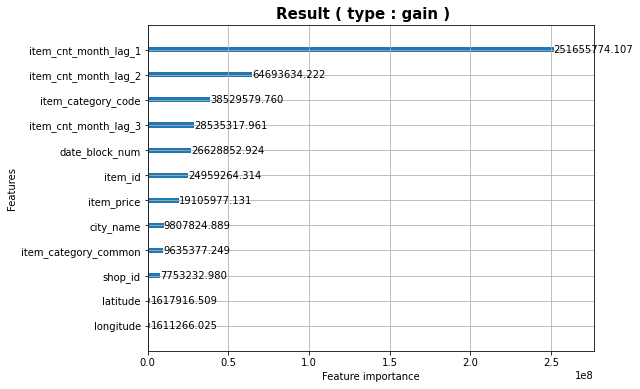

In [46]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1,1, figsize=(8,6))
lgb.plot_importance(model, max_num_features=50, importance_type='gain', ax=ax)
ax.set_title("Result ( type : gain )   ", fontweight="bold", fontsize=15)
ax.patch.set_alpha(0) 
plt.show()

## Submission part

In [48]:
test_X


,shop_id,item_id,date_block_num,item_category_common,item_category_code,city_name,latitude,longitude,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_price
10842077,5,5037,34,5,19,3,59.218876,39.893276,0.0,1.0,3.0,1.000000
10842078,5,5320,34,13,55,3,59.218876,39.893276,0.0,0.0,0.0,0.000000
10842079,5,5233,34,5,19,3,59.218876,39.893276,1.0,3.0,1.0,0.889753
10842080,5,5232,34,5,23,3,59.218876,39.893276,0.0,0.0,1.0,0.878348
10842081,5,5268,34,5,20,3,59.218876,39.893276,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,13,55,20,53.198627,50.113987,1.0,0.0,0.0,0.209646
11056273,45,16188,34,14,64,20,53.198627,50.113987,0.0,0.0,0.0,1.000000
11056274,45,15757,34,13,55,20,53.198627,50.113987,0.0,0.0,0.0,0.220126
11056275,45,19648,34,11,40,20,53.198627,50.113987,0.0,0.0,0.0,0.108996


In [49]:
model.predict(test_X)

array([0.50562233, 0.04618627, 0.89629327, ..., 0.07123428, 0.04167556,
       0.07596813])

In [50]:
Y_test = model.predict(test_X).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission

,ID,item_cnt_month
0,0,0.505622
1,1,0.046186
2,2,0.896293
3,3,0.130182
4,4,0.744107
...,...,...
214195,214195,0.222499
214196,214196,0.080684
214197,214197,0.071234
214198,214198,0.041676


In [52]:
submission.to_csv('submission.csv', index=False)
